In [1]:
import matplotlib.pyplot as plt
import time

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


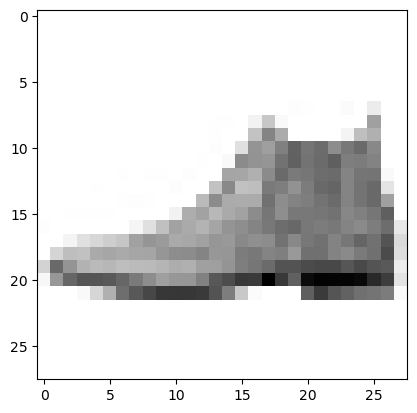

In [5]:
for _ in test_dataloader:
    plt.imshow(_[0][0][0], cmap='Greys')
    plt.show()
    break

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = 'cpu'
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        
model = NeuralNetwork().to(device)

Using cuda device


In [7]:
try:
    model = NeuralNetwork().to(device)
    model.load_state_dict(torch.load("model.FFNN.pth"))
    print('loaded model')
except:
    model = NeuralNetwork().to(device)
    print("couldn't load model")

loaded model


In [8]:
total_params = 0
for params in model.parameters():
    total_params += params.nelement()
print('Total parameters:', total_params)

Total parameters: 669706


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.680507  [    0/60000]
loss: 0.781739  [ 6400/60000]
loss: 0.554192  [12800/60000]
loss: 0.767131  [19200/60000]
loss: 0.682518  [25600/60000]
loss: 0.672333  [32000/60000]
loss: 0.748354  [38400/60000]
loss: 0.739140  [44800/60000]
loss: 0.734981  [51200/60000]
loss: 0.709272  [57600/60000]
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.699831 

Epoch 2
-------------------------------
loss: 0.655777  [    0/60000]
loss: 0.759286  [ 6400/60000]
loss: 0.534118  [12800/60000]
loss: 0.751213  [19200/60000]
loss: 0.668940  [25600/60000]
loss: 0.657639  [32000/60000]
loss: 0.729187  [38400/60000]
loss: 0.727971  [44800/60000]
loss: 0.720544  [51200/60000]
loss: 0.693781  [57600/60000]
Test Error: 
 Accuracy: 75.5%, Avg loss: 0.683929 

Epoch 3
-------------------------------
loss: 0.633572  [    0/60000]
loss: 0.738516  [ 6400/60000]
loss: 0.516383  [12800/60000]
loss: 0.736803  [19200/60000]
loss: 0.656921  [25600/60000]
loss: 0.644952  [32000/600

In [13]:
torch.save(model.state_dict(), "model.FFNN.pth")
print("Saved PyTorch Model State to model.FFNN.pth")

Saved PyTorch Model State to FFNN.pt


In [14]:
def manual_calc(x, model):
    pred = []
    x = nn.Flatten()(x)
    state = model.state_dict()
    for num, feature in enumerate(x):
        feature = state['linear_relu_stack.0.weight'] @ feature + state['linear_relu_stack.0.bias']
        feature = torch.max(feature, torch.zeros_like(feature))
        feature = state['linear_relu_stack.2.weight'] @ feature + state['linear_relu_stack.2.bias']
        feature = torch.max(feature, torch.zeros_like(feature))
        feature = state['linear_relu_stack.4.weight'] @ feature + state['linear_relu_stack.4.bias']
        max_index, max_value = None, -torch.inf
        for i, value in enumerate(feature):
            if value > max_value:
                max_index = i
                max_value = value
        pred.append(max_index)
    return torch.Tensor(pred).to(device)


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            if (manual_calc(X, model) == pred.argmax(1)).type(torch.float).sum().item() != len(X):
                print('error')
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 77.4%, Avg loss: 0.643341 



In [15]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x.to(device))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Predicted: "Coat", Actual: "Shirt"


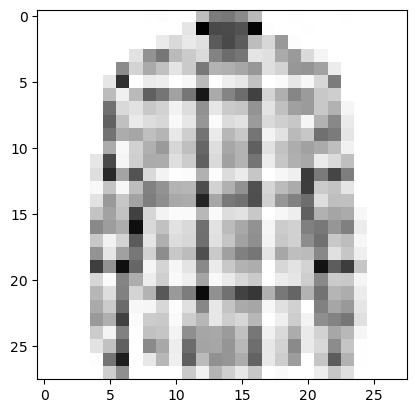

Predicted: "Sandal", Actual: "Sneaker"


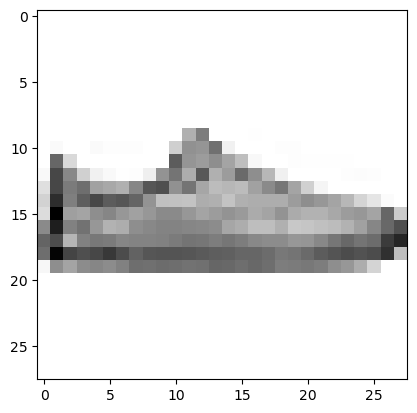

Predicted: "Pullover", Actual: "Coat"


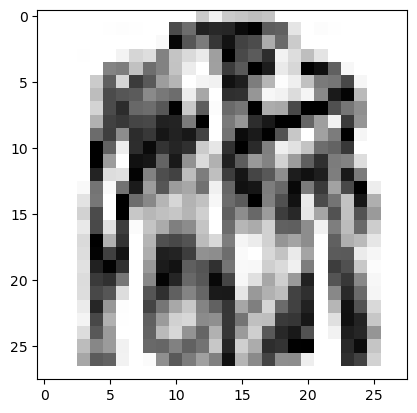

Predicted: "T-shirt/top", Actual: "Pullover"


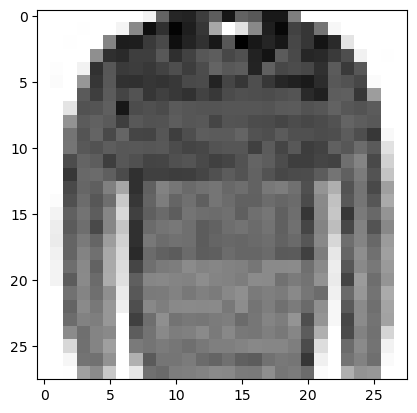

Predicted: "Sneaker", Actual: "Sandal"


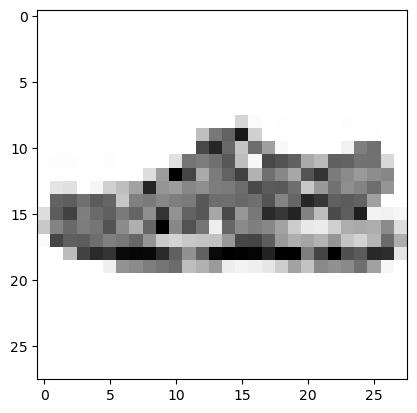

Predicted: "Sneaker", Actual: "Ankle boot"


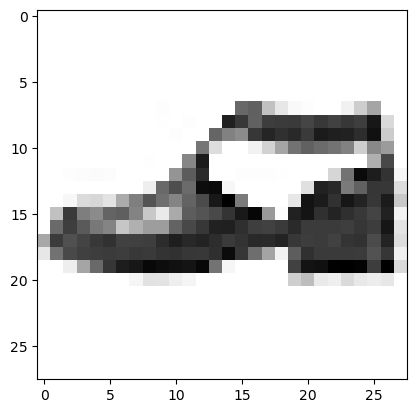

Predicted: "Pullover", Actual: "Coat"


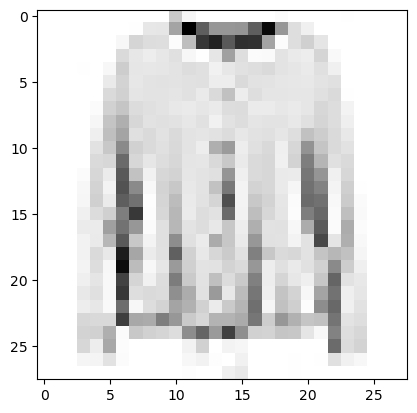

Predicted: "Coat", Actual: "Shirt"


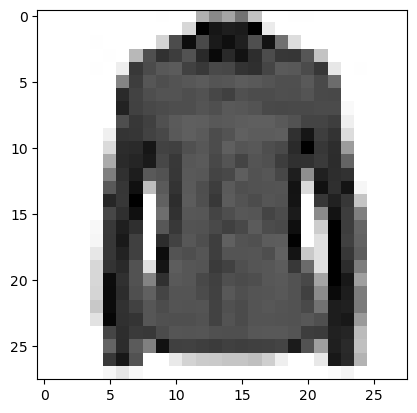

Predicted: "Dress", Actual: "T-shirt/top"


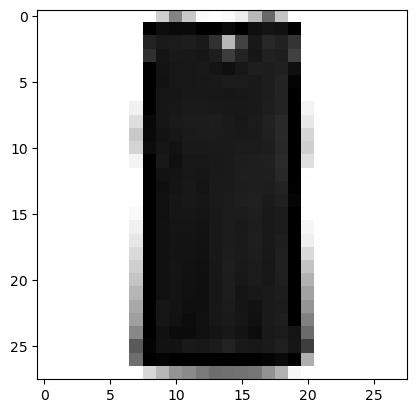

Predicted: "T-shirt/top", Actual: "Shirt"


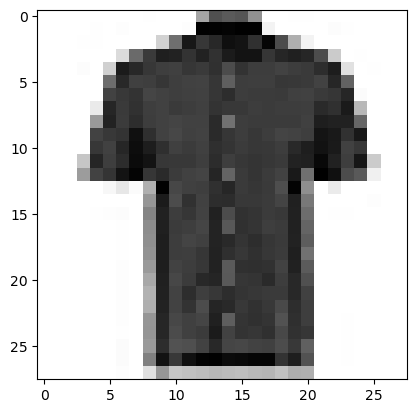

Predicted: "Ankle boot", Actual: "Sneaker"


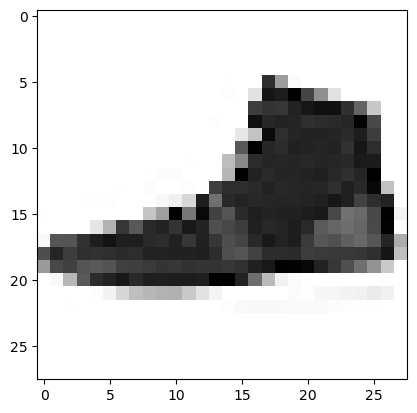

In [16]:
model.eval()
num_show = 10
with torch.no_grad():
    for x, y in test_data:
        pred = model(x.to(device))
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        if predicted != actual:
            print(f'Predicted: "{predicted}", Actual: "{actual}"')
            plt.imshow(x[0], cmap='Greys')
            plt.show()
            num_show -= 1
        if num_show < 0:
            break